In [1]:
import spacy
spacy_nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
import utility_functions as utils
import importlib
import pandas as pd
from transformers import pipeline, DistilBertTokenizer

importlib.reload(utils)

custom_stop_words = list(STOP_WORDS)  # Existing stop words
custom_stop_words.extend(["ll", "ve", "'em", "em", "ho", "fo", "ah", "de"])  # Tokens which doesn't really make sense to have them.

/Users/borosabel/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = pd.read_excel('/Users/borosabel/Documents/Uni/Thesis/PopMIR/Data/Excel/baseline_w_topics_w_entity.xlsx', engine='openpyxl')

In [3]:
df['Lyrics'] = df['Lyrics'].apply(utils.cleanup)

In [4]:
# Load the sentiment analysis pipeline
classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)

/Users/borosabel/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [5]:
tokenizer = DistilBertTokenizer.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')
classifier = pipeline("text-classification", model='bhadresh-savani/distilbert-base-uncased-emotion', top_k=None)

def get_sentiment(text):
    max_length = 500
    tokens = tokenizer.tokenize(text)
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]

    all_scores = []

    for chunk in chunks:
        chunk_text = tokenizer.convert_tokens_to_string(chunk)
        results = classifier(chunk_text)
        
        for result in results:
            all_scores.append({emotion['label']: emotion['score'] for emotion in result})

    # Aggregate scores
    aggregated_scores = {}
    for score_dict in all_scores:
        for emotion, score in score_dict.items():
            if emotion in aggregated_scores:
                aggregated_scores[emotion] += score
            else:
                aggregated_scores[emotion] = score

    # Average the scores
    num_entries = len(all_scores)
    aggregated_scores = {emotion: score / num_entries for emotion, score in aggregated_scores.items()}

    return aggregated_scores

In [6]:
from tqdm.auto import tqdm

tqdm.pandas(desc="Extracting entities")
df['Emotion Scores'] = df['Lyrics'].progress_apply(get_sentiment)

Extracting entities:   0%|          | 0/1360 [00:00<?, ?it/s]

In [8]:
emotion_df = df['Emotion Scores'].apply(pd.Series)
df = pd.concat([df, emotion_df], axis=1).drop('Emotion Scores', axis=1)
emotion_columns = emotion_df.columns.tolist()

In [10]:
df.to_pickle('df_w_emotion.pkl')

In [154]:
# Calculating average emotion scores by coast
average_emotions = df.groupby('Coast')[['joy', 'anger', 'sadness', 'fear', 'love', 'surprise']].mean().reset_index()

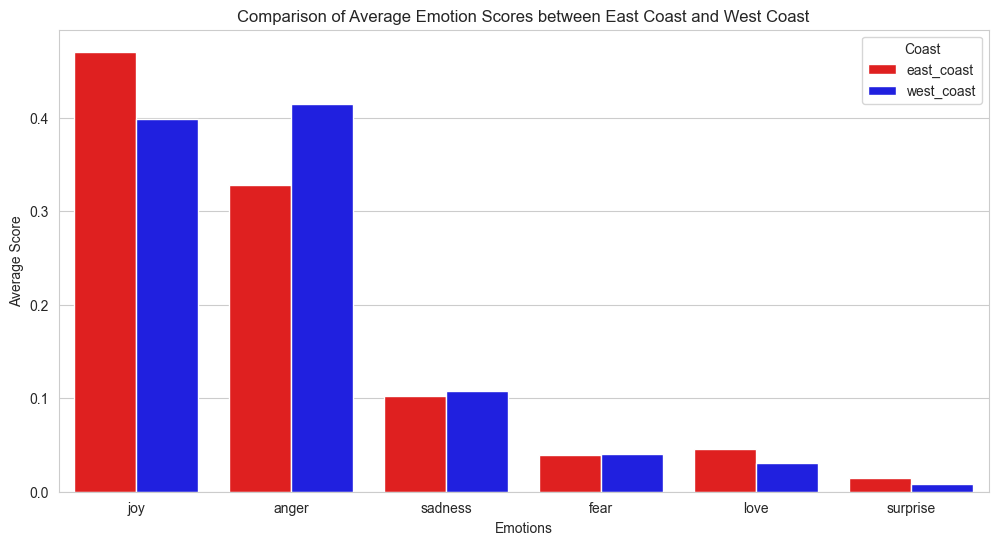

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting
sns.barplot(data=average_emotions.melt(id_vars=['Coast']), x='variable', y='value', hue='Coast', palette={"east_coast": "red", "west_coast": "blue"})
plt.title('Comparison of Average Emotion Scores between East Coast and West Coast')
plt.xlabel('Emotions')
plt.ylabel('Average Score')
plt.legend(title='Coast')

plt.show()

In [156]:
df_w_topics_0 = df[df['Topic Model Index'] == 0]
df_w_topics_1 = df[df['Topic Model Index'] == 1]

In [158]:
# Calculating average emotion scores by coast
average_emotions_0 = df_w_topics_0.groupby('Coast')[['joy', 'anger', 'sadness', 'fear', 'love', 'surprise']].mean().reset_index()
average_emotions_1 = df_w_topics_1.groupby('Coast')[['joy', 'anger', 'sadness', 'fear', 'love', 'surprise']].mean().reset_index()

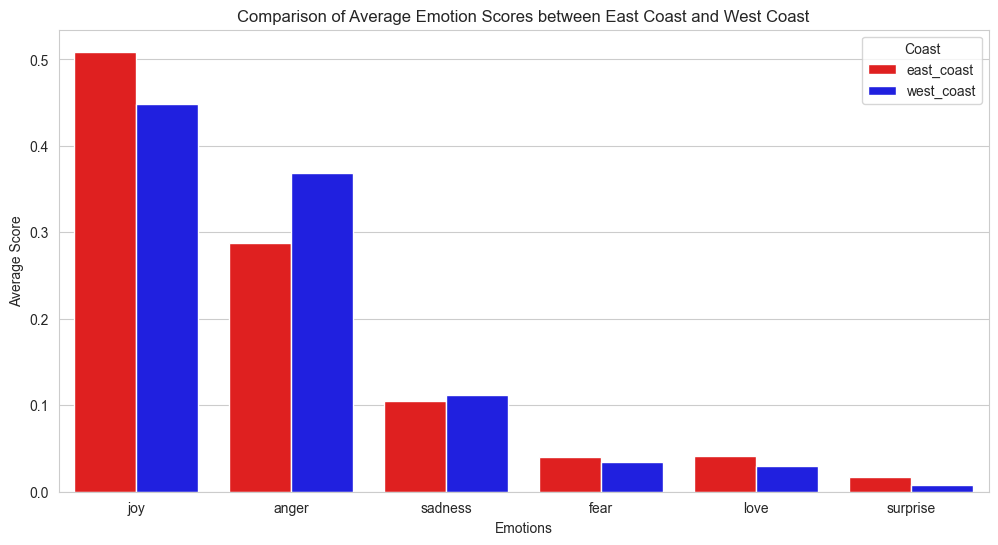

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting
sns.barplot(data=average_emotions_0.melt(id_vars=['Coast']), x='variable', y='value', hue='Coast', palette={"east_coast": "red", "west_coast": "blue"})
plt.title('Comparison of Average Emotion Scores between East Coast and West Coast')
plt.xlabel('Emotions')
plt.ylabel('Average Score')
plt.legend(title='Coast')

plt.show()

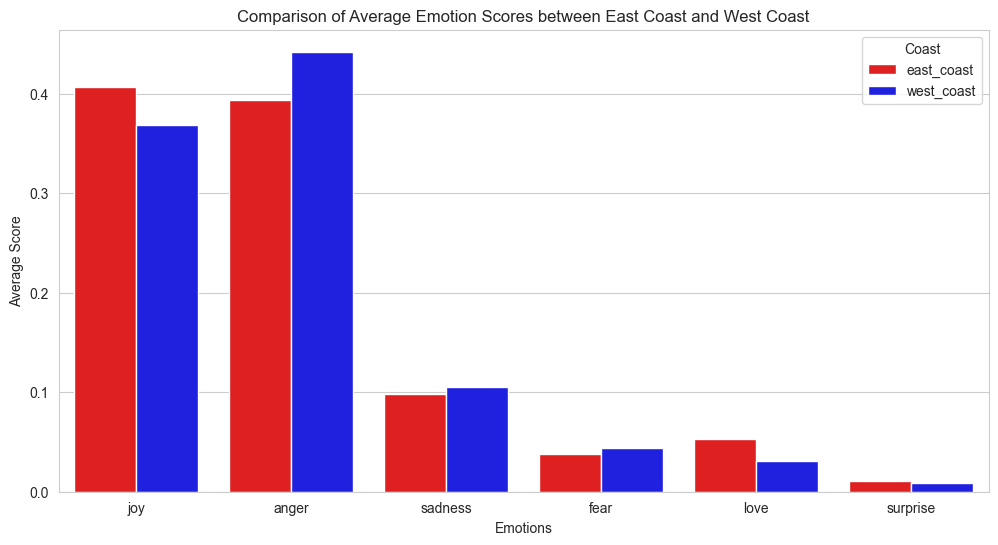

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting
sns.barplot(data=average_emotions_1.melt(id_vars=['Coast']), x='variable', y='value', hue='Coast', palette={"east_coast": "red", "west_coast": "blue"})
plt.title('Comparison of Average Emotion Scores between East Coast and West Coast')
plt.xlabel('Emotions')
plt.ylabel('Average Score')
plt.legend(title='Coast')

plt.show()

In [165]:
# Coherent multimodal analysis

In [191]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [192]:
emotion_data = df[emotion_columns]

/Users/borosabel/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/borosabel/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


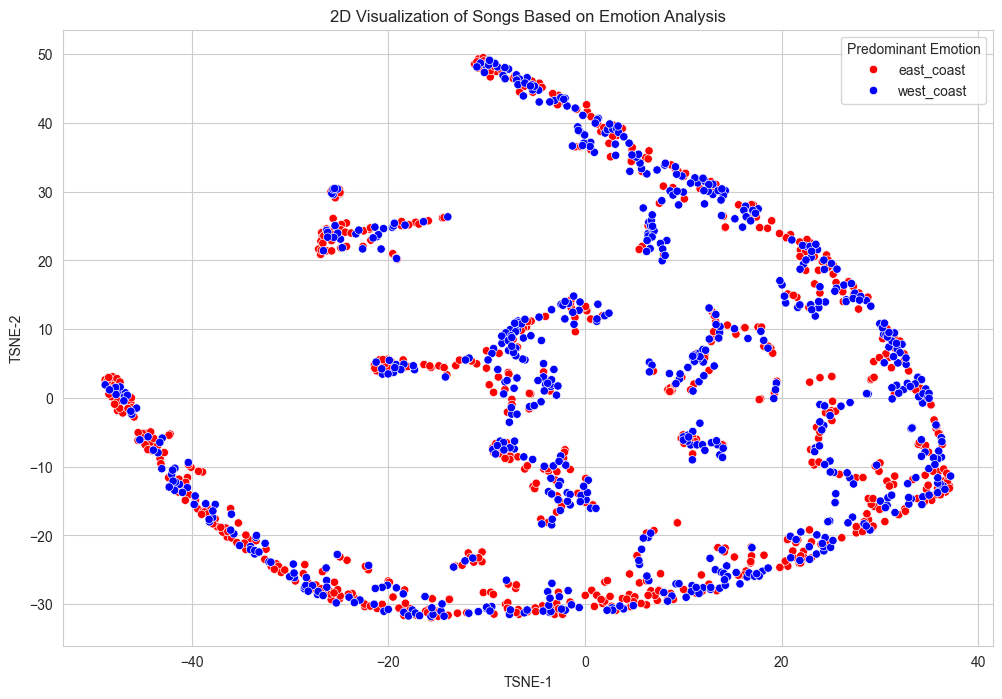

In [198]:
# Apply PCA
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(emotion_data.values)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame(tsne_result, columns=['t-SNE1', 't-SNE2'])

# Determine the predominant emotion for coloring
df['predominant_emotion'] = emotion_df.idxmax(axis=1)

# Plotting
plt.figure(figsize=(12, 8))
# sns.scatterplot(x='t-SNE1', y='t-SNE2', hue=df['predominant_emotion'], data=tsne_df)
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue=df['Coast'], data=tsne_df, palette={'east_coast': 'red', 'west_coast': 'blue'})
plt.title('2D Visualization of Songs Based on Emotion Analysis')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.legend(title='Predominant Emotion')
plt.show()

In [185]:
df_0 = df[df['Topic Model Index'] == 0].reset_index(drop=True)

In [186]:
emotion_data = df_0[emotion_columns]

/Users/borosabel/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/borosabel/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


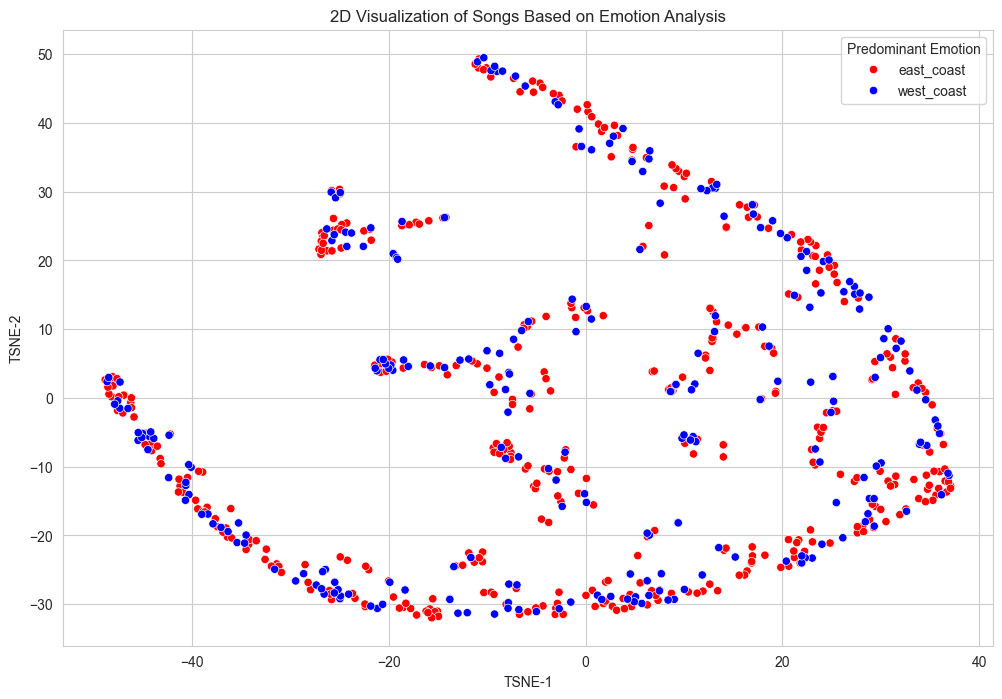

In [199]:
# Apply PCA
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(emotion_data.values)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame(tsne_result, columns=['t-SNE1', 't-SNE2'])

# Determine the predominant emotion for coloring
df['predominant_emotion'] = emotion_df.idxmax(axis=1)

# Plotting
plt.figure(figsize=(12, 8))
# sns.scatterplot(x='t-SNE1', y='t-SNE2', hue=df['predominant_emotion'], data=tsne_df)
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue=df_0['Coast'], data=tsne_df, palette={'east_coast': 'red', 'west_coast': 'blue'})
plt.title('2D Visualization of Songs Based on Emotion Analysis')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.legend(title='Predominant Emotion')
plt.show()

In [200]:
df_1 = df[df['Topic Model Index'] == 1].reset_index(drop=True)

In [201]:
emotion_data = df_1[emotion_columns]

/Users/borosabel/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/borosabel/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


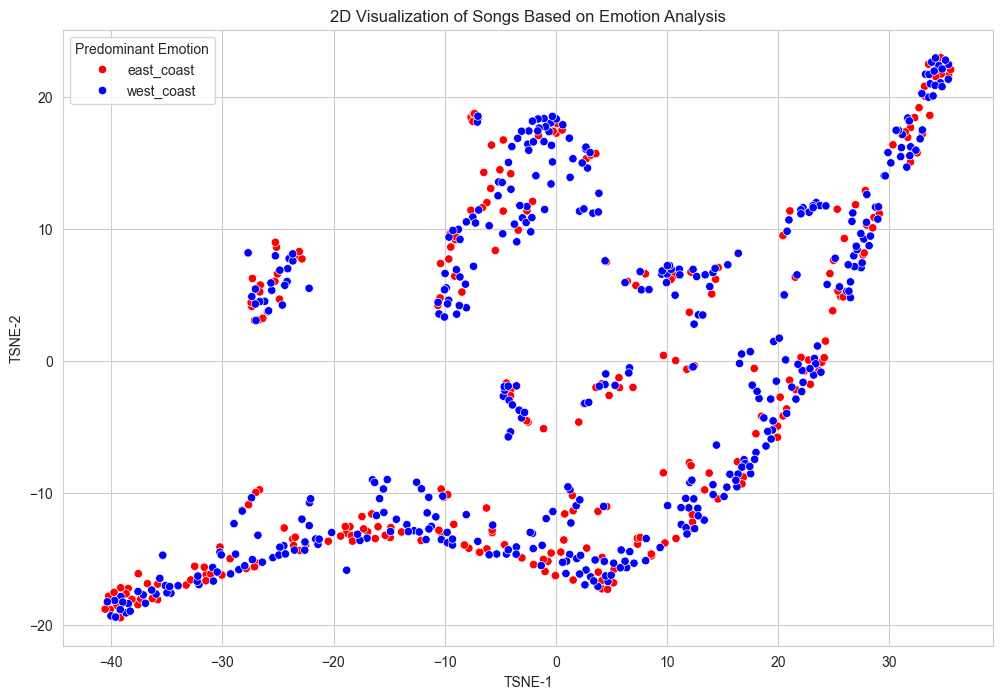

In [202]:
# Apply PCA
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(emotion_data.values)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame(tsne_result, columns=['t-SNE1', 't-SNE2'])

# Determine the predominant emotion for coloring
df['predominant_emotion'] = emotion_df.idxmax(axis=1)

# Plotting
plt.figure(figsize=(12, 8))
# sns.scatterplot(x='t-SNE1', y='t-SNE2', hue=df['predominant_emotion'], data=tsne_df)
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue=df_1['Coast'], data=tsne_df, palette={'east_coast': 'red', 'west_coast': 'blue'})
plt.title('2D Visualization of Songs Based on Emotion Analysis')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.legend(title='Predominant Emotion')
plt.show()